# Qcodes example with DelegateInstrument driver

This notebooks explains how to use the `DelegateInstrument` driver.

## About
The goal of the `DelegateInstrument` driver is to make it easier to combine different parameters together into a new "virtual" instrument. Each parameter on a `DelegateInstrument` can point to one or more parameters on other instruments in the station.

## Usage
The way it's used is mainly by specifying an entry in the station YAML. For instance, let's say you want to use a magnetic field coil. The driver has a method set_field(value, block), that by default is set to block=True, which means the field is ramped in a way that blocks further execution until the desired value is reached. However, let's say you are creating a measurement in which you want the parameter to be set, and while the value is ramping, you want to measure other parameters. This can be done by using `DelegateInstrument` and specifying a custom `setter` for the parameter that gets and sets the magnetic field.

By default, each parameter is represented by a `DelegateParameter`. The `DelegateInstrument` also supports passing multiple source parameters to a given parameter. In order to do this, simply specify multiple parameters in the dictionary values  under the `parameters` key.

In [1]:
%%writefile example.yaml

instruments:
  field_X:
    type: qcodes.tests.instrument_mocks.MockField

  field:
    type: qcodes.instrument.delegate.DelegateInstrument
    init:
      parameters:
        X:
          - field_X.field
        ramp_rate:
          - field_X.ramp_rate
        combined:
          - field_X.field
          - field_X.ramp_rate
      set_initial_values_on_load: true
      initial_values:
        ramp_rate: 1.0
      setters:
        X:
          method: field_X.set_field
          block: false

Writing example.yaml


In [2]:
import qcodes as qc

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210517-9179-qcodes.log


In [3]:
station = qc.Station(config_file="example.yaml")

In [4]:
field_X = station.load_field_X()
field = station.load_field(station=station)

In [5]:
field.X()

0.0

In [6]:
field.X(1.)

In [7]:
field.X()

0.00012070337931315104

In [8]:
field.X()

0.0002836028734842936

In [9]:
field.X()

0.0004405816396077474

In [10]:
field.X()

0.0005964318911234538

As you can see, the field is now ramped in the background with the specified ramp rate. Now, let's try to create a measurement that uses this ability, and ramps the field in the background while measuring:

In [11]:
field.ramp_rate(10.)
field_X.field(0.0)

In [12]:
field.X()

0.0

In [13]:
import time
meas = qc.Measurement(station=station)
meas.register_parameter(field.X)

with meas.run() as datasaver:
    for B in [0.1, 0.0]:
        field.X(B)
        while field.X() != B:
            datasaver.add_result((field.X, field.X()))
            time.sleep(0.01)
    datasaver.flush_data_to_database()

Starting experimental run with id: 56. 


<AxesSubplot:>

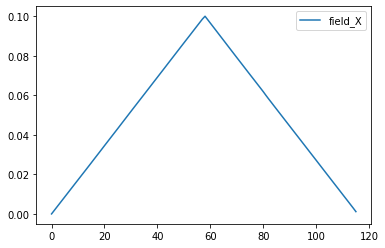

In [14]:
datasaver.dataset.to_pandas_dataframe().plot()

When specifying multiple source parameters on a given parameter, the grouped parameter will automatically return a `namedtuple` that returns both values.

In [15]:
field.combined()

combined(field=0.0, ramp_rate=10.0)

We can now also create a custom parameter that does a simple calculation based on the current parameters.

In [16]:
import numpy as np

def calculate_ramp_time(X, ramp_rate):
    """Calculate ramp time in seconds"""
    dfield = np.abs(field.target_field - X)
    return 60. * dfield/ramp_rate

In [17]:
field._create_and_add_parameter(
    group_name="ramp_time",
    station=station,
    paths=["field_X.field", "field_X.ramp_rate"],
    formatter=calculate_ramp_time
)

In [18]:
field.ramp_rate(1.0)
field.target_field = 0.1
field.ramp_time()

6.0

In [19]:
field.X(0.1)

In [20]:
field.ramp_time()

5.992941379547119

In [21]:
import time
time.sleep(1.)
field.ramp_time()

4.982635021209717

In [22]:
import time
time.sleep(1.)
field.ramp_time()

3.9721693992614755